In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

# Crear el entorno
env = gym.make('FrozenLake-v1', is_slippery=True)
print("Entorno FrozenLake creado")
print(f"Estados: {env.observation_space.n}")
print(f"Acciones: {env.action_space.n}")

Entorno FrozenLake creado
Estados: 16
Acciones: 4


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
class SARSAAgent:
    def __init__(self, n_states, n_actions):
        # Parámetros
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = 0.1    # α (alpha)
        self.discount_factor = 0.99 # γ (gamma)
        self.epsilon = 1.0          # exploración inicial
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        # Tabla Q inicializada en ceros
        self.q_table = np.zeros((n_states, n_actions))

    def choose_action(self, state):
        """Política epsilon-greedy"""
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # explorar
        else:
            return np.argmax(self.q_table[state])  # explotar

    def update_q(self, state, action, reward, next_state, next_action):
        """
        Actualización SARSA:
        Q(s,a) = Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
        """
        current_q = self.q_table[state][action]
        next_q = self.q_table[next_state][next_action]

        # Fórmula SARSA
        target = reward + self.discount_factor * next_q
        self.q_table[state][action] += self.learning_rate * (target - current_q)

    def decay_epsilon(self):
        """Reduce la exploración gradualmente"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

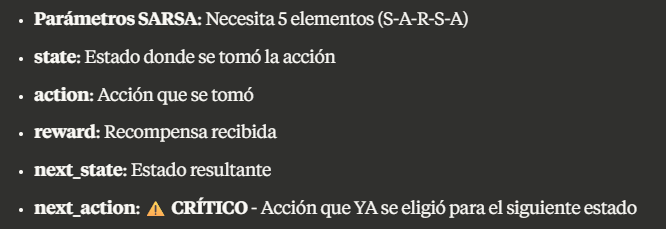

In [4]:
def entrenar_sarsa(episodes=5000):
    agent = SARSAAgent(env.observation_space.n, env.action_space.n)
    rewards_por_episodio = []

    print("Entrenando con SARSA...")

    for episode in range(episodes):
        # Iniciar episodio
        state = env.reset()
        action = agent.choose_action(state)  # Primera acción

        total_reward = 0

        while True:
            # Ejecutar acción
            next_state, reward, done, info = env.step(action)
            total_reward += reward

            if done:
                # Episodio terminado
                agent.q_table[state][action] += agent.learning_rate * (reward - agent.q_table[state][action])
                break
            else:
                # Elegir siguiente acción
                next_action = agent.choose_action(next_state)

                # Actualizar Q con SARSA
                agent.update_q(state, action, reward, next_state, next_action)

                # Avanzar al siguiente paso
                state = next_state
                action = next_action

        # Reducir exploración
        agent.decay_epsilon()
        rewards_por_episodio.append(total_reward)

        # Mostrar progreso
        if (episode + 1) % 1000 == 0:
            avg_reward = np.mean(rewards_por_episodio[-100:])
            print(f"Episodio {episode + 1}: Recompensa promedio = {avg_reward:.3f}, Epsilon = {agent.epsilon:.3f}")

    return agent, rewards_por_episodio

# Entrenar el agente
agente_sarsa, recompensas = entrenar_sarsa()

Entrenando con SARSA...
Episodio 1000: Recompensa promedio = 0.670, Epsilon = 0.010
Episodio 2000: Recompensa promedio = 0.570, Epsilon = 0.010
Episodio 3000: Recompensa promedio = 0.620, Epsilon = 0.010
Episodio 4000: Recompensa promedio = 0.690, Epsilon = 0.010
Episodio 5000: Recompensa promedio = 0.630, Epsilon = 0.010


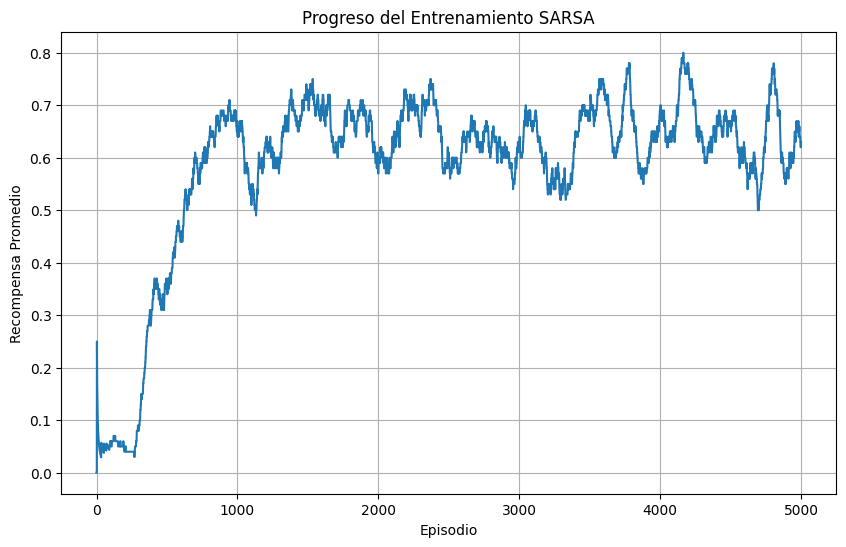

Recompensa promedio final: 0.630


In [5]:
plt.figure(figsize=(10, 6))

# Calcular promedio móvil para suavizar la gráfica
window = 100
promedio_movil = []
for i in range(len(recompensas)):
    inicio = max(0, i - window + 1)
    promedio_movil.append(np.mean(recompensas[inicio:i+1]))

plt.plot(promedio_movil)
plt.title('Progreso del Entrenamiento SARSA')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Promedio')
plt.grid(True)
plt.show()

print(f"Recompensa promedio final: {np.mean(recompensas[-100:]):.3f}")

In [6]:
def mostrar_politica(q_table):
    """Muestra la política aprendida de forma visual"""
    politica = np.argmax(q_table, axis=1)
    acciones = ['←', '↓', '→', '↑']

    print("Política aprendida por SARSA:")
    print("(0=←, 1=↓, 2=→, 3=↑)")

    for i in range(4):
        fila = []
        for j in range(4):
            estado = i * 4 + j
            fila.append(acciones[politica[estado]])
        print(' '.join(fila))

mostrar_politica(agente_sarsa.q_table)

Política aprendida por SARSA:
(0=←, 1=↓, 2=→, 3=↑)
← ↓ ← ↓
← ← → ←
↑ ↓ ← ←
← → ↓ ←


In [7]:
def evaluar_agente(agent, episodes=100):
    """Evalúa qué tan bien funciona el agente entrenado"""
    exitos = 0
    recompensas_eval = []

    # Sin exploración para evaluación
    epsilon_original = agent.epsilon
    agent.epsilon = 0  # Solo explotar, no explorar

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        pasos = 0

        while pasos < 100:  # Límite de pasos
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)

            total_reward += reward
            state = next_state
            pasos += 1

            if done:
                if reward > 0:  # Llegó al objetivo
                    exitos += 1
                break

        recompensas_eval.append(total_reward)

    # Restaurar epsilon
    agent.epsilon = epsilon_original

    tasa_exito = exitos / episodes
    recompensa_promedio = np.mean(recompensas_eval)

    return tasa_exito, recompensa_promedio

tasa_exito, recompensa_prom = evaluar_agente(agente_sarsa)
print(f"\n=== EVALUACIÓN FINAL ===")
print(f"Tasa de éxito: {tasa_exito:.1%}")
print(f"Recompensa promedio: {recompensa_prom:.3f}")


=== EVALUACIÓN FINAL ===
Tasa de éxito: 67.0%
Recompensa promedio: 0.670


In [8]:
def demostrar_episodio(agent):
    """Muestra un episodio completo paso a paso"""
    print("\n=== DEMOSTRACIÓN DE UN EPISODIO ===")

    state = env.reset()
    agent.epsilon = 0  # Sin exploración

    acciones_str = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
    paso = 0

    print(f"Estado inicial: {state}")

    while paso < 20:  # Máximo 20 pasos
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)

        print(f"Paso {paso + 1}:")
        print(f"  Acción: {acciones_str[action]}")
        print(f"  Nuevo estado: {next_state}")
        print(f"  Recompensa: {reward}")

        if done:
            if reward > 0:
                print("  ¡ÉXITO! Llegó al objetivo")
            else:
                print("  Cayó en un hoyo")
            break

        state = next_state
        paso += 1

    if paso >= 20:
        print("  Episodio muy largo, terminando...")

demostrar_episodio(agente_sarsa)


=== DEMOSTRACIÓN DE UN EPISODIO ===
Estado inicial: 0
Paso 1:
  Acción: Izquierda
  Nuevo estado: 4
  Recompensa: 0.0
Paso 2:
  Acción: Izquierda
  Nuevo estado: 4
  Recompensa: 0.0
Paso 3:
  Acción: Izquierda
  Nuevo estado: 0
  Recompensa: 0.0
Paso 4:
  Acción: Izquierda
  Nuevo estado: 4
  Recompensa: 0.0
Paso 5:
  Acción: Izquierda
  Nuevo estado: 4
  Recompensa: 0.0
Paso 6:
  Acción: Izquierda
  Nuevo estado: 8
  Recompensa: 0.0
Paso 7:
  Acción: Arriba
  Nuevo estado: 9
  Recompensa: 0.0
Paso 8:
  Acción: Abajo
  Nuevo estado: 8
  Recompensa: 0.0
Paso 9:
  Acción: Arriba
  Nuevo estado: 4
  Recompensa: 0.0
Paso 10:
  Acción: Izquierda
  Nuevo estado: 0
  Recompensa: 0.0
Paso 11:
  Acción: Izquierda
  Nuevo estado: 0
  Recompensa: 0.0
Paso 12:
  Acción: Izquierda
  Nuevo estado: 0
  Recompensa: 0.0
Paso 13:
  Acción: Izquierda
  Nuevo estado: 0
  Recompensa: 0.0
Paso 14:
  Acción: Izquierda
  Nuevo estado: 0
  Recompensa: 0.0
Paso 15:
  Acción: Izquierda
  Nuevo estado: 4
  Recom

In [9]:
print("\n=== TABLA Q FINAL ===")
print("Valores Q para cada estado-acción:")
print("Filas = Estados, Columnas = Acciones (0=←, 1=↓, 2=→, 3=↑)")
print(np.round(agente_sarsa.q_table, 3))

# Mostrar mejores acciones por estado
print("\nMejor acción para cada estado:")
for estado in range(16):
    mejor_accion = np.argmax(agente_sarsa.q_table[estado])
    valor_max = np.max(agente_sarsa.q_table[estado])
    acciones_str = ['←', '↓', '→', '↑']
    print(f"Estado {estado:2d}: {acciones_str[mejor_accion]} (valor: {valor_max:.3f})")

# Cerrar entorno
env.close()
print("\n¡Entrenamiento SARSA completado!")


=== TABLA Q FINAL ===
Valores Q para cada estado-acción:
Filas = Estados, Columnas = Acciones (0=←, 1=↓, 2=→, 3=↑)
[[0.406 0.361 0.377 0.371]
 [0.017 0.161 0.004 0.027]
 [0.201 0.071 0.083 0.066]
 [0.    0.037 0.    0.   ]
 [0.437 0.224 0.299 0.283]
 [0.    0.    0.    0.   ]
 [0.126 0.045 0.191 0.   ]
 [0.    0.    0.    0.   ]
 [0.362 0.414 0.315 0.509]
 [0.468 0.523 0.417 0.359]
 [0.507 0.378 0.283 0.23 ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.437 0.474 0.717 0.412]
 [0.615 0.888 0.652 0.665]
 [0.    0.    0.    0.   ]]

Mejor acción para cada estado:
Estado  0: ← (valor: 0.406)
Estado  1: ↓ (valor: 0.161)
Estado  2: ← (valor: 0.201)
Estado  3: ↓ (valor: 0.037)
Estado  4: ← (valor: 0.437)
Estado  5: ← (valor: 0.000)
Estado  6: → (valor: 0.191)
Estado  7: ← (valor: 0.000)
Estado  8: ↑ (valor: 0.509)
Estado  9: ↓ (valor: 0.523)
Estado 10: ← (valor: 0.507)
Estado 11: ← (valor: 0.000)
Estado 12: ← (valor: 0.000)
Estado 13: → (valor: 0.717)
Estado 14: ↓ (valor: 0.888)